In [58]:
from ultralytics import YOLO
from pathlib import Path
import pprint

model = YOLO('best.pt')

DATA_YAML = Path('../dataset/data.yaml')
print(DATA_YAML.resolve())

with open(DATA_YAML, 'r') as f:
    print(f.read())
val_results = model.val(data=str(DATA_YAML))
# print(val_results)

D:\DlProject\ulcer-detection-app\dataset\data.yaml
# Path is relative to this data.yaml file
path: D:/DlProject/ulcer-detection-app/dataset

# Image folders
train: train/images
val: valid/images
test: test/images

nc: 1
names: ['FootUlcer']

Ultralytics 8.3.240  Python-3.10.19 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 290.295.8 MB/s, size: 28.5 KB)
val: Scanning D:\DlProject\ulcer-detection-app\dataset\valid\labels.cache... 234 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 234/234 116.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 3.4it/s 4.4s0.2s
                   all        234        305      0.905      0.793      0.885      0.628      0.903      0.794      0.882      0.592
Speed: 3.1ms preprocess, 4

### Ultralytics return an ultralytics rresults/metrics object

In [59]:
metric_dict = val_results.results_dict
pprint.pprint(metric_dict)

{'fitness': 1.220342744702175,
 'metrics/mAP50(B)': 0.8845987565924326,
 'metrics/mAP50(M)': 0.8824975799195953,
 'metrics/mAP50-95(B)': 0.6282069519622759,
 'metrics/mAP50-95(M)': 0.592135792739899,
 'metrics/precision(B)': 0.9046834105400557,
 'metrics/precision(M)': 0.9030424128134824,
 'metrics/recall(B)': 0.7934426229508197,
 'metrics/recall(M)': 0.7939638870806521}


In [60]:
metrics = val_results.results_dict

with open('val_metrics.txt', 'w') as f:
    for k, v in metrics.items():
        f.write(f'{k}: {v}\n')

### Visual Evaluation

In [61]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

TEST_IMG_DIR = Path('../dataset/test/images')

for i in list(TEST_IMG_DIR.glob('*'))[:5]:
    results = model.predict(source=str(i), conf= 0.25, imgsz= 640)[0]
    print(type(results.boxes.xyxy))
    print(results.boxes.xyxy.shape)
    print(results.boxes.xyxy.device)

    print('type->results->maks->data: ',type(results.masks.data))
    print('results->mask->data->shape: ',results.masks.data.shape)
    print('results->mask->data->device: ',results.masks.data.device)



image 1/1 d:\DlProject\ulcer-detection-app\notebook\..\dataset\test\images\0003_png.rf.226ec17e0a7d0f1624ce84e8bda349a4.jpg: 640x640 1 FootUlcer, 26.4ms
Speed: 3.5ms preprocess, 26.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)
<class 'torch.Tensor'>
torch.Size([1, 4])
cuda:0
type->results->maks->data:  <class 'torch.Tensor'>
results->mask->data->shape:  torch.Size([1, 640, 640])
results->mask->data->device:  cuda:0

image 1/1 d:\DlProject\ulcer-detection-app\notebook\..\dataset\test\images\0010_png.rf.f02ac3acdad8cbe40ed723434430df48.jpg: 640x640 1 FootUlcer, 26.6ms
Speed: 4.2ms preprocess, 26.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)
<class 'torch.Tensor'>
torch.Size([1, 4])
cuda:0
type->results->maks->data:  <class 'torch.Tensor'>
results->mask->data->shape:  torch.Size([1, 640, 640])
results->mask->data->device:  cuda:0

image 1/1 d:\DlProject\ulcer-detection-app\notebook\..\dataset\test\images\0022_png.rf.a80dd496e78ee85f70d17151c3

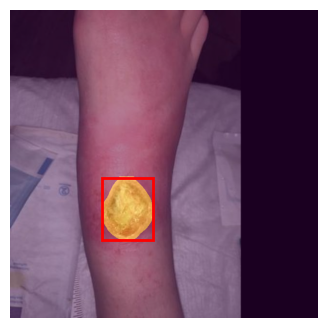

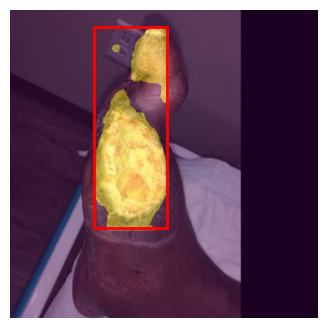

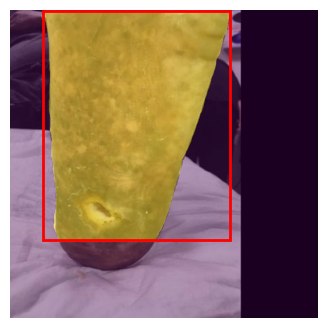

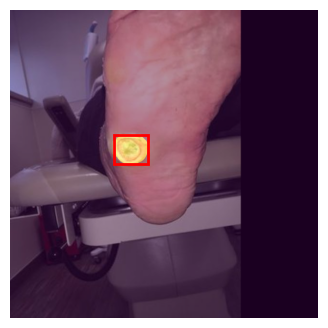

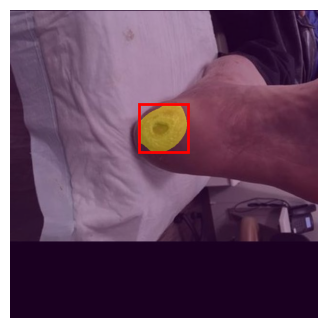

In [62]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

TEST_IMG_DIR = Path('../dataset/test/images')

def visualize_predictions(img_path, results, show=True):
    img = cv2.imread(str(img_path))[:, :, ::-1]    #convert it to RGB format
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    ax = plt.gca()

    # Draw masks
    if results.masks is not None:
        for mask in results.masks.data.cpu().numpy():
            ax.imshow(mask, alpha= 0.4)

    # Draw bounding boxes
    for box in results.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = box
        rect = plt.Rectangle(
            (x1, y1),
            x2-x1,
            y2-y1,
            fill= False,
            linewidth= 2,
            edgecolor= 'red'
        )
        ax.add_patch(rect)

    if show:
            plt.axis('off'); plt.show()

for i in list(TEST_IMG_DIR.glob('*'))[:5]:
    results = model.predict(source=str(i), conf= 0.25, imgsz= 640, verbose= False)[0]
    visualize_predictions(i, results)

In [63]:
def read_yolo_seg_label(label_p):
    instance= []
    with open(label_p, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue

            class_id = int(parts[0])

            parts = list(map(float,parts[1:]))

            polygon_mask = [
                (parts[i], parts[i+1]) for i in range(0, len(parts), 2)
            ]

            instance.append({
                'class_id': class_id,
                'polygon_mask': polygon_mask
            })
        return instance

In [64]:
import numpy as np
from PIL import Image, ImageDraw

img_p = list(TEST_IMG_DIR.glob('*'))[0]
label_p = Path('../dataset/test/labels/')/(img_p.stem+'.txt')
print(label_p)
instances = read_yolo_seg_label(label_p)
print(instances[0]['polygon_mask'])

..\dataset\test\labels\0003_png.rf.226ec17e0a7d0f1624ce84e8bda349a4.txt
[(0.340625, 0.565625), (0.3375, 0.56875), (0.3375, 0.5703125), (0.334375, 0.5734375), (0.334375, 0.575), (0.3328125, 0.5765625), (0.3328125, 0.578125), (0.3296875, 0.58125), (0.3296875, 0.5828125), (0.328125, 0.584375), (0.328125, 0.5859375), (0.3265625, 0.5875), (0.3265625, 0.5890625), (0.325, 0.590625), (0.325, 0.5921875), (0.3234375, 0.59375), (0.3234375, 0.596875), (0.321875, 0.5984375), (0.321875, 0.6015625), (0.3203125, 0.603125), (0.3203125, 0.6046875), (0.31875, 0.60625), (0.31875, 0.609375), (0.3171875, 0.6109375), (0.3171875, 0.6140625), (0.315625, 0.615625), (0.315625, 0.6171875), (0.3125, 0.6203125), (0.3125, 0.6234375), (0.3109375, 0.625), (0.3109375, 0.6265625), (0.309375, 0.628125), (0.309375, 0.6296875), (0.3078125, 0.63125), (0.3078125, 0.6328125), (0.30625, 0.634375), (0.30625, 0.6375), (0.3046875, 0.6390625), (0.3046875, 0.6421875), (0.303125, 0.64375), (0.303125, 0.646875), (0.3015625, 0.6484375

In [65]:
def polygon_to_mask(polygon_normalized, img_size):
    w,h = img_size
    poly_pixel = [(int(w*x), int(h*y)) for x,y in polygon_normalized]
    mask = Image.new('L', (w, h), 0)
    ImageDraw.Draw(mask).polygon(poly_pixel, outline=1, fill=1)
    return np.array(mask, dtype=np.uint8)

number_of_images = len(list(TEST_IMG_DIR.glob('*')))
iou_sum = 0
count = 0

for i in range(number_of_images):
    img_p = list(TEST_IMG_DIR.glob('*'))[i]
    label_p = Path('../dataset/test/labels/')/(img_p.stem+'.txt')
    instances = read_yolo_seg_label(label_p)
    img = Image.open(img_p)
    w,h = img.size

    pred = model.predict(source= str(img_p), conf= 0.25, imgsz= 640)[0]
    if pred.masks is None:
        continue

    pred_masks= pred.masks.data.cpu().numpy()

    if instances:
        gt_mask = polygon_to_mask(instances[0]['polygon_mask'], (w, h))
        best_iou= 0
        for pm in pred_masks:
            pm_resize = cv2.resize(pm.astype('uint8'), (w,h), interpolation=cv2.INTER_NEAREST)
            inter = np.logical_and(gt_mask, pm_resize).sum()
            union = np.logical_or(gt_mask, pm_resize).sum()
            iou = inter/union if union>0 else 0
            best_iou = max(best_iou, iou)
        iou_sum = iou_sum + best_iou
        count = count + 1
    else:
        print('No GT instances in label file')

print('average iou : ', iou_sum/count)
print(count,"   ", number_of_images)

average iou :  0.7513257786544231
114     116
